In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import smtplib
import time
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

## Loading the Dataset

In [2]:
df = pd.read_csv('OnlineRetail.csv')
    
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Dataset Overview

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

## Summary Statistics

In [5]:
# Summary Statistics for numerical data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [6]:
# Summary Statistics for categorical data
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


## Data Cleaning

### Handle missing values

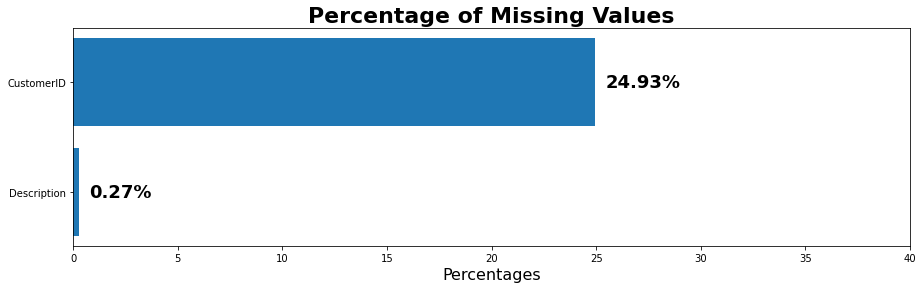

In [7]:
# Calculate the percentage of missing values for each column
missing = df.isnull().sum()
missing_percentage = (missing[missing > 0] / df.shape[0]) * 100
missing_percentage.sort_values(ascending=True, inplace=True)
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage)

for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
     ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')
ax.set_xlim([0, 40])
plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages', fontsize=16)
plt.show()

In [8]:
# Remove rows with missing values
df = df.dropna(subset=['CustomerID', 'Description'])

In [9]:
df.isnull().sum().sum()

0

### Handle Duplicates

In [10]:
print(f'The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed')
df.drop_duplicates(inplace=True)

The dataset contains 5225 duplicate rows that need to be removed


### Removing Canceled Transactions (Negative Quantities)

In [11]:
df = df[df['Quantity'] > 0]

### Correcting StockCode Anomailes

In [12]:
print(f"The number of unique stock code in the dataset is: {df['StockCode'].nunique()}")

The number of unique stock code in the dataset is: 3665


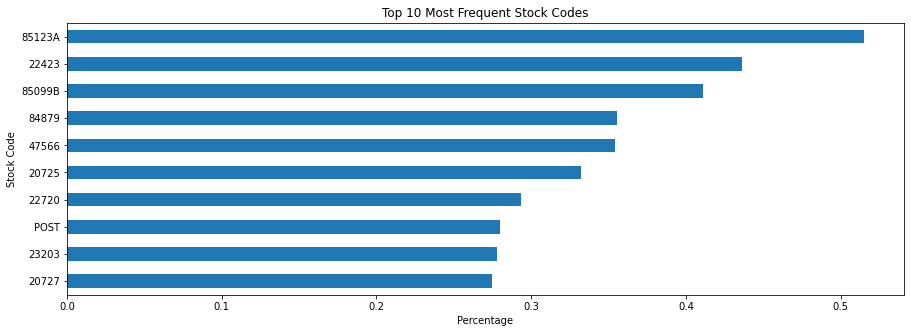

In [13]:
# Find the top 10 most frequent stock codes
top_10_stock_codes = df['StockCode'].value_counts(normalize=True).head(10) * 100

# Plotting the top 10 stock codes
plt.figure(figsize=(15, 5))
top_10_stock_codes.plot(kind='barh')

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Percentage')
plt.ylabel('Stock Code')
plt.gca().invert_yaxis()
plt.show()

### Treating Zero Unit Price

In [14]:
df['UnitPrice'].describe().reset_index()

,index,UnitPrice
0,count,392732.000000
1,mean,3.125596
2,std,22.240725
3,min,0.000000
4,25%,1.250000
5,50%,1.950000
6,75%,3.750000
7,max,8142.750000


In [15]:
df[df['UnitPrice'] == 0].describe()[['Quantity']]

,Quantity
count,40.000000
mean,347.100000
std,1978.311813
min,1.000000
25%,1.000000
50%,4.500000
75%,24.000000
max,12540.000000


In [16]:
# Remove rows with zero unit price
df = df[df['UnitPrice'] > 0]

## Feature Engineering

In [18]:
# Convert 'InvoiceDate' to a datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate the total spending for each transaction
df['TotalSpending'] = df['Quantity'] * df['UnitPrice']

# Calculate the recency of purchase for each customer
max_date = df['InvoiceDate'].max()
df['Recency'] = max_date - df.groupby('CustomerID')['InvoiceDate'].transform('max')

# Convert to the number of days
df['Recency'] = df['Recency'].dt.days  

# Calculate the order frequency for each customer
df['OrderFrequency'] = df.groupby('CustomerID')['InvoiceNo'].transform('nunique')

# Calculate the average basket size for each customer
df['BasketSize'] = df.groupby(['CustomerID', 'InvoiceNo'])['Quantity'].transform('sum')
df = df.drop_duplicates(subset=['CustomerID', 'InvoiceNo'])  

# Group data by CustomerID
df = df.groupby('CustomerID').agg({
    'Recency': 'min',
    'OrderFrequency': 'mean',
    'TotalSpending': 'sum',
    'BasketSize': 'mean'
}).reset_index()


df.head(5)


,CustomerID,Recency,OrderFrequency,TotalSpending,BasketSize
0,12346.0,325,1.0,77183.60,74215.000000
1,12347.0,1,7.0,163.16,351.142857
2,12348.0,74,4.0,331.36,585.250000
3,12349.0,18,1.0,15.00,631.000000
4,12350.0,309,1.0,25.20,197.000000


# PCA

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


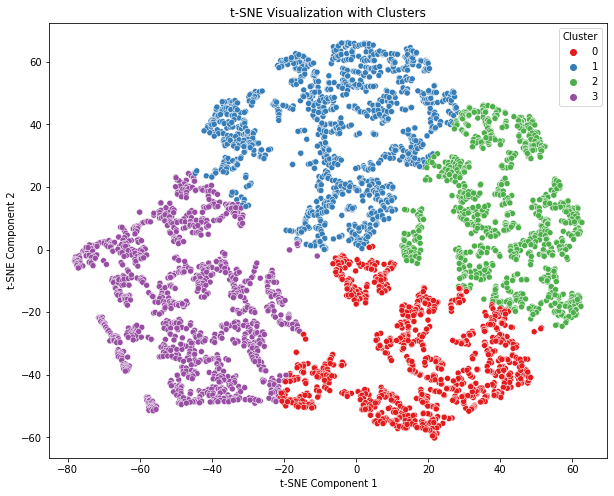

In [19]:
# Exclude categorical columns before PCA
num_cols = df.select_dtypes(include='number')

# Standardize numerical features for PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(num_cols)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=min(num_cols.shape[0], num_cols.shape[1]))
pca_result = pca.fit_transform(scaled_data)

# Add PCA results to the DataFrame
for i in range(pca_result.shape[1]):
    df[f'PCA_Component_{i+1}'] = pca_result[:, i]

# Apply t-SNE on the PCA
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(pca_result)
df['t-SNE_Component_1'] = tsne_result[:, 0]
df['t-SNE_Component_2'] = tsne_result[:, 1]

# Define the number of clusters
K = 4

kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)

# Perform K-means clustering on the t-SNE
df['Cluster'] = kmeans.fit_predict(tsne_result)

# Create a scatter plot of the t-SNE result with cluster coloring
plt.figure(figsize=(10, 8))
sns.scatterplot(x='t-SNE_Component_1', y='t-SNE_Component_2', hue='Cluster', data=df, palette='Set1')
plt.title('t-SNE Visualization with Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.show()

In [20]:
# Calculate cluster-specific metrics
cluster_metrics = df.groupby('Cluster').agg({
    'Recency': 'mean',            
    'OrderFrequency': 'mean',    
    'TotalSpending': 'mean',     
    'BasketSize': 'mean',        
}).reset_index()

# Rename the columns for clarity
cluster_metrics.columns = ['Cluster', 'AvgRecency', 'AvgPurchaseFrequency', 'AvgSpending', 'AvgBasketSize']

# Print or display the cluster metrics
print(cluster_metrics)

   Cluster  AvgRecency  AvgPurchaseFrequency  AvgSpending  AvgBasketSize
0        0   45.033092              4.548087   165.205026     205.437840
1        1   33.587510              7.516023   471.758956     287.613176
2        2   35.902821              3.047022   102.291724     212.103738
3        3  232.500418              1.730159   381.151362     286.981724


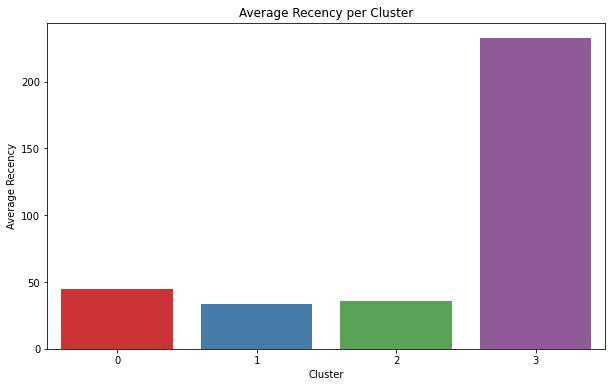

In [21]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='AvgRecency', data=cluster_metrics, palette='Set1')
plt.title('Average Recency per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Recency')
plt.show()

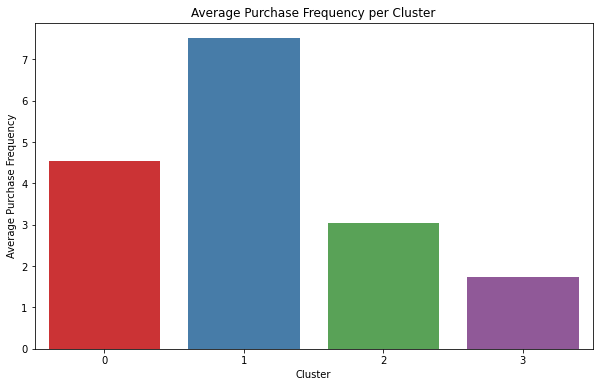

In [22]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='AvgPurchaseFrequency', data=cluster_metrics, palette='Set1')
plt.title('Average Purchase Frequency per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Purchase Frequency')
plt.show()

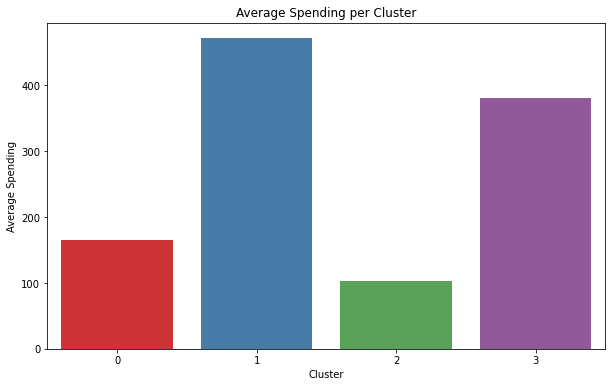

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='AvgSpending', data=cluster_metrics, palette='Set1')
plt.title('Average Spending per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Spending')
plt.show()

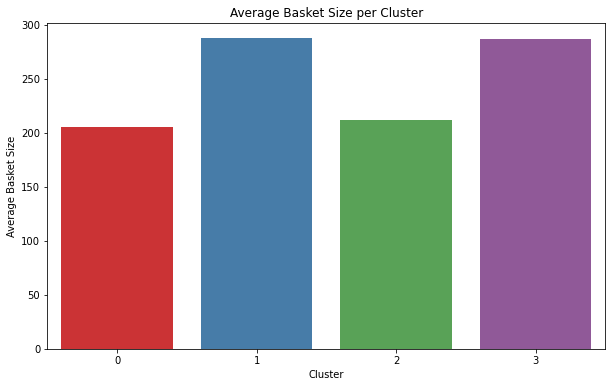

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='AvgBasketSize', data=cluster_metrics, palette='Set1')
plt.title('Average Basket Size per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Basket Size')
plt.show()

For K=2:
  - Silhouette Score: 0.39
  - WCSS: 6007424.00
For K=3:
  - Silhouette Score: 0.44
  - WCSS: 3329082.00
For K=4:
  - Silhouette Score: 0.41
  - WCSS: 2480095.75
For K=5:
  - Silhouette Score: 0.38
  - WCSS: 2039392.62
For K=6:
  - Silhouette Score: 0.41
  - WCSS: 1635016.00
For K=7:
  - Silhouette Score: 0.42
  - WCSS: 1301436.25
For K=8:
  - Silhouette Score: 0.42
  - WCSS: 1094838.12
For K=9:
  - Silhouette Score: 0.42
  - WCSS: 973854.12
For K=10:
  - Silhouette Score: 0.40
  - WCSS: 874119.94


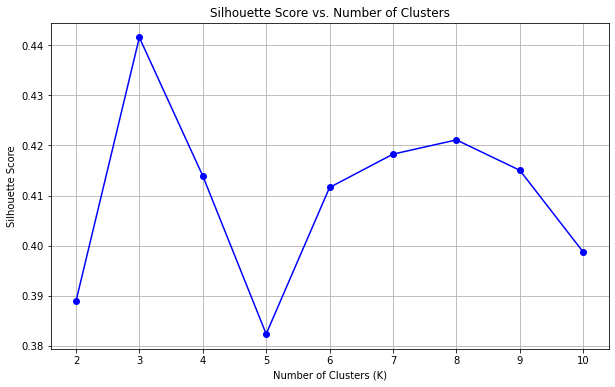

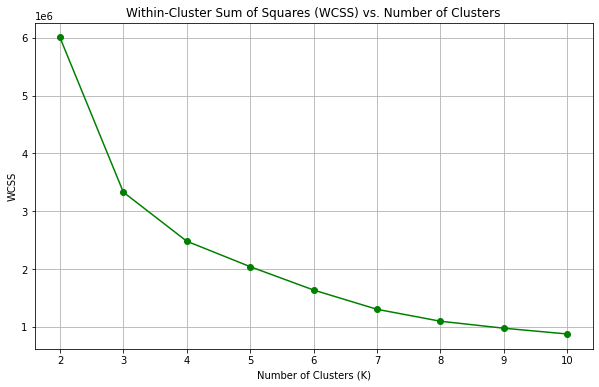

In [25]:
# Create empty lists to store silhouette scores and WCSS
silhouette_scores = []
wcss = []

# Create a range of K values to try
K_range = range(2, 11)

for K in K_range:
    # Fit K-means clustering for each K
    kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
    kmeans.fit(tsne_result)  # Use t-SNE result for clustering
    
    # Calculate the silhouette score for the current K
    silhouette_avg = silhouette_score(tsne_result, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

    # Calculate the within-cluster sum of squares (WCSS)
    wcss.append(kmeans.inertia_)
    
    print(f"For K={K}:")
    print(f"  - Silhouette Score: {silhouette_avg:.2f}")
    print(f"  - WCSS: {wcss[-1]:.2f}")

# Plot the silhouette scores to visualize the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Plot the WCSS to find the "elbow point" for choosing K
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, marker='o', linestyle='-', color='g')
plt.title('Within-Cluster Sum of Squares (WCSS) vs. Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [26]:
def suggest_products(customer):
    return ["Product1", "Product2", "Product3"]

# Define a function to send personalized recommendation emails
def send_recommendation_email(customer):
    # Get customer information
    customer_id = customer['CustomerID']
    #customer_email = customer['Email']  

    # Generate product recommendations for the customer
    recommended_products = suggest_products(customer)

# Schedule the email sending task to run once a week on Friday night
def schedule_email_task():
    # Schedule the task to run at Friday night
    schedule.every().friday.at("20:00").do(send_recommendation_emails)
